In [ ]:
#install dependencies 
!pip install BeautifulSoup
!pip install requests 
!pip install selenium
!pip install cloudscraper
!pip install pandas

  Using cached BeautifulSoup-3.2.2.tar.gz (32 kB)
  Using cached BeautifulSoup-3.2.1.tar.gz (31 kB)
  Using cached BeautifulSoup-3.2.0.tar.gz (31 kB)
ERROR: Could not find a version that satisfies the requirement BeautifulSoup (from versions: 3.2.0, 3.2.1, 3.2.2)
ERROR: No matching distribution found for BeautifulSoup
     |████████████████████████████████| 96 kB 2.9 MB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 


In [ ]:
#imports 
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
import cloudscraper
import pandas as pd

In [ ]:
## API call to get required data (Ivan)
url = "https://api.opensea.io/api/v1/assets"
punks = []

for i in range(0, 10001):
    querystring = {"token_ids": str(i),
                    "asset_contract_address":"0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb",
                   "order_direction":"desc",
                   "offset":"0",
                   "limit":"20"}
    response = requests.request("GET", url, params=querystring)
    #print(i, end=" ")
    if response.status_code != 200:
        print('error')
        continue
    else: 
        punks.append(response.json()['assets'])

punks_df2 = pd.DataFrame(list(map(lambda x: x[0], punks)))
punks_df2.to_csv('punks.csv')

In [ ]:
#Data cleaning (Ivan)
punks_df  = pd.read_csv("punks.csv")
punks_df_clean = punks_df.drop(["background_color", "image_preview_url", "image_thumbnail_url", "image_original_url",
 "animation_url", "animation_original_url", "description", "permalink", "decimals", "token_metadata", "owner",
 "sell_orders", "creator", "top_bid", "listing_date", "is_presale", "transfer_fee", "transfer_fee_payment_token", "external_link", "collection"], 1)
punks_df_clean = punks_df_clean.drop(punks_df.columns[0], 1)
punks_df_clean['asset_contract'] = punks_df_clean['asset_contract'].apply(lambda x: ast.literal_eval(x)) 
punks_df_clean['created_date'] = punks_df_clean['asset_contract'].apply(lambda x: x['created_date'])
punks_df_clean = punks_df_clean.drop("asset_contract", 1)
no_prices_index = punks_df_clean[punks_df_clean['last_sale'].isnull()].index
print("There are " + str(len(no_prices_index)) + " cryptopunks which have not been sold before, drop these rows")
print("")
punks_df_clean = punks_df_clean.drop(no_prices_index)
punks_df_clean['last_sale'] = punks_df_clean['last_sale'].apply(lambda x: ast.literal_eval(x))
punks_df_clean['payment_token'] = punks_df_clean['last_sale'].apply(lambda x: x['payment_token']['symbol'])
print("transactions are carried out in the following currencies: " + str(punks_df_clean['payment_token'].unique()))
print("proceed to get ETH prices and USD prices of each cryptopunk")
print("")
punks_df_clean = punks_df_clean.drop("payment_token", 1)
punks_df_clean["eth_price"] = punks_df_clean['last_sale'].apply(lambda x: float(x['total_price']))/(10.**18) #prices in wei
punks_df_clean["usd_price"] = punks_df_clean['last_sale'].apply(lambda x: float(x['payment_token']['usd_price'])) * punks_df_clean["eth_price"]
free_punks = punks_df_clean[punks_df_clean['eth_price'] == 0].index
print("upon further inspection there are " + str(len(free_punks)) + " cryptopunks with no prices. We believe that the eth prices may have been so small that the digits were cut off. we will remove those")
print("this leaves us with " + str(len(punks_df_clean)) + " cryptopunks in this dataset")
punks_df_clean = punks_df_clean.drop(free_punks)
punks_df_clean['event_timestamp'] = punks_df_clean['last_sale'].apply(lambda x: x['event_timestamp'])
punks_df_clean = punks_df_clean.drop("last_sale", 1)
punks_df_clean['traits'] = punks_df_clean['traits'].apply(lambda x: ast.literal_eval(x))

def getTraits(lst):
    values = []
    for d in lst:
        if d['value'] not in values:
            values.append(d['value'])
    return values

punks_df_clean['traits'] = punks_df_clean['traits'].apply(lambda x: getTraits(x))
traits_list = []
for index, value in punks_df_clean['traits'].items():
    for trait in value:
        if trait not in traits_list:
            traits_list.append(trait)
d = {}
for trait in traits_list:
    d[trait] = []
    for index, value in punks_df_clean['traits'].items():
        if trait in value:
            d[trait].append(1)
        else:
            d[trait].append(0)
traits_df = pd.DataFrame(d)
traits_df = traits_df.reset_index()
punks_df_clean = punks_df_clean.reset_index()
punks_df_clean = pd.concat([punks_df_clean, traits_df], 1)
punks_df_clean.drop(['created_date', 'traits', 'Male', 'Mohawk'], 1, inplace = True)
punks_df_clean.drop([punks_df_clean.columns[9]], 1, inplace = True)
punks_df_clean.to_csv('punks_cleaned.csv')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


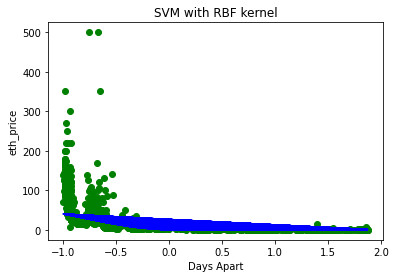

14.372341054736983
1522.9041189106335
39.02440414549124


In [ ]:
##10 fold CV 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
punks_df1 = pd.read_csv('punks_cleaned2.csv')
punks_df2 = punks_df1[punks_df1['num_sales'] == 1]

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

x = np.asarray(punks_df2['Days Apart'])
y = np.asarray(punks_df2['eth_price'])
y = y.reshape(-1,1)
x = x.reshape(-1,1)

sc_x = StandardScaler()
x = sc_x.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y)

regressor = SVR(kernel='rbf')
regressor.fit(x_train,y_train)

plt.scatter(x_train, y_train, color = 'green')
plt.plot(x_train, regressor.predict(x_train), color = 'blue')
plt.title('SVM with RBF kernel')
plt.xlabel('Days Apart')
plt.ylabel('eth_price')
plt.show()

print(mae(y_test, regressor.predict(x_test)))
print(mse(y_test, regressor.predict(x_test)))
print(mse(y_test, regressor.predict(x_test), squared= False))

self train ccn below:

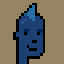

-1

In [ ]:
from google.colab.patches import cv2_imshow
from skimage import io

# Read image from web image
image = io.imread('https://lh3.googleusercontent.com/7bRocEaoBrWYBX3vThkHj4kAV3b3mKG-Kem85xeT-D8oHpvQ19kcoiBd9mIFeNU0GrwZGvj6Oc5NAEGBSsGlrww')
#print(image.shape)
image = cv2.resize(image, (64, 64))
cv2_imshow(image)
cv2.waitKey()

In [ ]:
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Activation, BatchNormalization, Dropout, MaxPooling2D
import pandas as pd
from skimage import io
import cv2
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/sample_data/punks_cleaned.csv')
images = [];
result = []

for ind in df.index:
    try:
        image = io.imread(df['image_url'][ind])
        image = cv2.resize(image, (128, 128))
        images.append(image)
        result.append([image, df['usd_price'][ind]])
    except Exception as e:
        print(e)
        continue

HTTP Error 500: Internal Server Error


In [ ]:
len(result)

5847

In [ ]:
headers = ['image', 'price']
df2 = pd.DataFrame(result, columns = headers)
df2["eth_price"] = df["eth_price"]

images = np.array(images)
images = images / 255.0

In [ ]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1
    # define the model input
    inputs = Input(shape=inputShape)
    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input appropriately
        if i == 0:
            x = inputs
        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.6)(x)
    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)
    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)
    # construct the CNN
    model = Model(inputs, x)
    # return the CNN
    return model

In [ ]:
split = train_test_split(df2, images, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split
model = create_cnn(128, 128, 3, regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_squared_error", optimizer=opt, metrics=["mean_squared_error"])

history = model.fit(x=trainImagesX, y=trainAttrX["eth_price"], 
    validation_data=(testImagesX, testAttrX["eth_price"]),
    epochs=150, batch_size=32) 

preds = model.predict(testImagesX)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/150
137/137 [==============================] - 96s 694ms/step - loss: 12675.9424 - mean_squared_error: 12675.9424 - val_loss: 17734.5039 - val_mean_squared_error: 17734.5039
Epoch 2/150
137/137 [==============================] - 95s 695ms/step - loss: 12631.1484 - mean_squared_error: 12631.1484 - val_loss: 17723.0234 - val_mean_squared_error: 17723.0234
Epoch 3/150
137/137 [==============================] - 95s 697ms/step - loss: 12614.5840 - mean_squared_error: 12614.5840 - val_loss: 17711.7012 - val_mean_squared_error: 17711.7012
Epoch 4/150
137/137 [==============================] - 95s 697ms/step - loss: 12602.2432 - mean_squared_error: 12602.2432 - val_loss: 17700.5664 - val_mean_squared_error: 17700.5664
Epoch 5/150
137/137 [==============================] - 95s 697ms/step - loss: 12589.8213 - mean_squared_error: 12589.8213 - val_loss: 17689.3770 - val_mean_squared_error: 17689.3770
Epoch 6/150
137/137 [==============================] - 95s 696ms/step - loss: 12577.8350 -

In [ ]:
mse_test = mean_squared_error(testAttrX["eth_price"],preds)
mse_train = mean_squared_error(trainAttrX["eth_price"],model.predict(trainImagesX))
print(mse_test, mse_train) 

#10060.92655631016 59319.02088229264 (dropout=0.25, batch size = 16)
#7246.9532777810455 19080.764081643996 (dropout=0.5, batch size = 16)
#214779.142002418 7696.40690924029 (dropout=0.55, batch size = 16)
#9962.678564979076 9151.075837143515 (dropout=0.6, batch size = 16)
#821491618.3952924 529651068.9911889 (dropout=0.75, batch size = 16)

14303.808223700582 9642.461026797859


In [ ]:
mse = mean_squared_error(df2["eth_price"],model.predict(images))
mae = mean_absolute_error(df2["eth_price"],model.predict(images))
print(mse, mae)

10808.196505868706 39.07358757561597


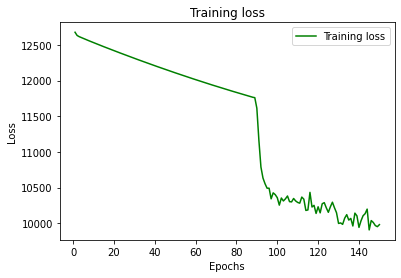

In [ ]:
train_loss = history.history["loss"]
epochs = range(1,151)
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

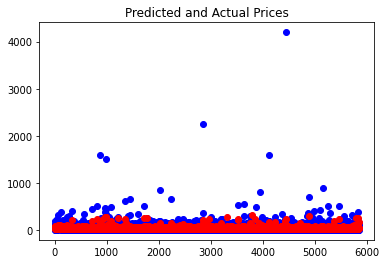

In [ ]:
# plot for training data
ax = plt.gca()
ax.scatter(trainAttrX.index, trainAttrX["eth_price"], color="b", label='actual')
ax.scatter(trainAttrX.index, model.predict(trainImagesX), color="r", label='predicted')
plt.title('Predicted and Actual Prices')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import libraries
import pandas as pd   
#Python must have package for data manipulation (organize, explore, massage, summarize, etc._.
import numpy as np   
#Array and Matricsprocessing package.
import matplotlib.pyplot as plt   
#Writes 2-dimensional graphs and plots (Others like seaborn, ggplotand basemapcan be integrated).
import statsmodels.api as sm
#Provides classes and functions for the estimation of many statistical models.
import seaborn as sns 
#Data visualization library based on matplotlib. Provides a high-level interface for drawing attractive and informative statistical graphics.
from sklearn.model_selection import train_test_split
#Considered as one of the best for working with complex data (associated with NumPy and SciPy_.
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
%matplotlib inline

df = pd.read_csv('C:/Users/tobyl/Downloads/punks_cleaned.csv')

df.head

X = df[['num_sales', 'Smile', 'Female', 'Hot Lipstick','Pipe','Pilot Helmet',
        'Big Shades','Straight Hair','Choker','Black Lipstick','Earring',
        'Clown Eyes Blue','Tiara','Bandana','Peak Spike','Normal Beard Black',
        'Horned Rim Glasses','Stringy Hair','Eye Patch','Do-rag','Chinstrap',
        'Headband','3D Glasses','Beanie','Clown Hair Green','Clown Nose',
        'Purple Lipstick','Pigtails','Frumpy Hair','Blue Eye Shadow',
        'Silver Chain','Blonde Bob','Regular Shades','Wild White Hair',
        'Messy Hair','Mole','Mustache','Crazy Hair','Nerd Glasses',
        'Straight Hair Blonde','Front Beard','Mohawk Thin','Goat','Knitted Cap',
        'Frown','Wild Blonde','Orange Side','Cap Forward','Cap','Handlebars',
        'Eye Mask','Purple Hair','Muttonchops','Dark Hair','Wild Hair','Cigarette',
        'Purple Eye Shadow','Hoodie','Clown Eyes Green','Pink With Hat','Small Shades',
        'Medical Mask','Green Eye Shadow','Normal Beard','Half Shaved','Classic Shades',
        'Shaved Head','Shadow Beard','Buck Teeth','Straight Hair Dark','Top Hat',
        'Big Beard','Front Beard Dark','Mohawk Dark','Cowboy Hat','VR','Vampire Hair',
        'Spots','Fedora','Tassle Hat','Luxurious Beard','Vape','Rosy Cheeks','Red Mohawk',
        'Police Cap','Blonde Short','Gold Chain','Zombie','Welding Goggles','Ape','Alien']]
y = df['eth_price']

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.3)

regressor = LinearRegression()
regressor.fit(X_train,  y_train) 
print(regressor.intercept_)    
y_pred = regressor.predict(X_test)
pred_out  = pd.DataFrame({'Actual':  y_test, 'Predicted': y_pred})
pred_out

pred_out1  = pred_out.head(20)
pred_out1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major',  linestyle='-', linewidth='0.5',  color='black')
plt.grid(which='minor',  linestyle=':', linewidth='0.5',  color='black')
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

FileNotFoundError: ignored

In [ ]:
z = list(range(1, 41))
plt.plot(z,test_out1)
plt.plot(z,pred_out1)
plt.show
print(pred_out)

df = pd.read_csv('C:/Users/tobyl/Downloads/punks_cleaned - Copy.csv')
df.plot(x='Days Apart', y='eth_price', style='o')  
plt.title('Price with Days Apart')  
plt.xlabel('Days Apart')  
plt.ylabel('Price')  
plt.show()
x= df['Days Apart']
print(x)

from sklearn.preprocessing import StandardScaler

scale= StandardScaler()
X = df[['Days Apart']]
y = df['eth_price']




X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

regressor = LinearRegression()  
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

Re = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
Re

print(X_train)

Re1 = Re.head(25)
Re1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.title('Price with Days Apart')  
plt.xlabel('Days Apart')  
plt.ylabel('Price')  
plt.show()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))



# New Section


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/punks_cleaned.csv')

df=df[df['eth_price']<1000]

In [ ]:
df.head()

,id,token_id,num_sales,image_url,name,eth_price,usd_price,event_timestamp,Modified Days,Date of Extracted,Days Apart,Smile,Female,Hot Lipstick,Pipe,Pilot Helmet,Big Shades,Straight Hair,Choker,Black Lipstick,Earring,Clown Eyes Blue,Tiara,Bandana,Peak Spike,Normal Beard Black,Horned Rim Glasses,Stringy Hair,Eye Patch,Do-rag,Chinstrap,Headband,3D Glasses,Beanie,Clown Hair Green,Clown Nose,Purple Lipstick,Pigtails,Frumpy Hair,Blue Eye Shadow,...,Purple Hair,Muttonchops,Dark Hair,Wild Hair,Cigarette,Purple Eye Shadow,Hoodie,Clown Eyes Green,Pink With Hat,Small Shades,Medical Mask,Green Eye Shadow,Normal Beard,Half Shaved,Classic Shades,Shaved Head,Shadow Beard,Buck Teeth,Straight Hair Dark,Top Hat,Big Beard,Front Beard Dark,Mohawk Dark,Cowboy Hat,VR,Vampire Hair,Spots,Fedora,Tassle Hat,Luxurious Beard,Vape,Rosy Cheeks,Red Mohawk,Police Cap,Blonde Short,Gold Chain,Zombie,Welding Goggles,Ape,Alien
0,158831,1,3,https://lh3.googleusercontent.com/7bRocEaoBrWY...,CryptoPunk #1,60.00,212213.4000,2020-11-30T18:44:26,2020-11-30,2021-10-14,318,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,176918,14,3,https://lh3.googleusercontent.com/WXyXUTvZaSwJ...,CryptoPunk #14,2.50,8842.2250,2018-12-07T19:47:12,2018-12-07,2021-10-14,1042,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,524886,53,3,https://lh3.googleusercontent.com/_oMP8QlIdvue...,CryptoPunk #53,129.99,459760.3311,2021-08-23T16:25:14,2021-08-23,2021-10-14,52,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,178528,89,3,https://lh3.googleusercontent.com/ysw3kO8EgWqr...,CryptoPunk #89,19.99,70702.4311,2020-09-06T15:31:48,2020-09-06,2021-10-14,403,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,178543,116,2,https://lh3.googleusercontent.com/taf59QUjkt95...,CryptoPunk #116,2.40,8488.5360,2017-07-17T06:25:03,2017-07-17,2021-10-14,1550,0,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.shape

(5847, 102)

In [ ]:
import plotly.express as px

a=pd.DataFrame(df.iloc[:,12:].sum(axis=0), columns=['count'])
a=a.sort_values(by=['count'])
col_names=list(a.index.values)
a.info()
#fig = px.bar(a, y="count",labels={'index':'features'})
fig = px.bar(a, y="count",x=a.index)

fig.show()

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, Alien to Female
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   90 non-null     int64
dtypes: int64(1)
memory usage: 1.4+ KB


In [ ]:

fig = px.scatter(df, x=df['event_timestamp'], y=df['eth_price'])
fig.show()

In [ ]:
colInd=[2,6]+(list(range(12,102)))
df2 = pd.DataFrame(df.iloc[:,colInd])

df2.rename(columns=lambda x: 'features-'+x, inplace=True)
df2=df2.rename({'features-token_id': 'token_id', 'features-eth_price': 'eth_price'}, axis=1)
df2

,token_id,eth_price,features-Smile,features-Female,features-Hot Lipstick,features-Pipe,features-Pilot Helmet,features-Big Shades,features-Straight Hair,features-Choker,features-Black Lipstick,features-Earring,features-Clown Eyes Blue,features-Tiara,features-Bandana,features-Peak Spike,features-Normal Beard Black,features-Horned Rim Glasses,features-Stringy Hair,features-Eye Patch,features-Do-rag,features-Chinstrap,features-Headband,features-3D Glasses,features-Beanie,features-Clown Hair Green,features-Clown Nose,features-Purple Lipstick,features-Pigtails,features-Frumpy Hair,features-Blue Eye Shadow,features-Silver Chain,features-Blonde Bob,features-Regular Shades,features-Wild White Hair,features-Messy Hair,features-Mole,features-Mustache,features-Crazy Hair,features-Nerd Glasses,...,features-Purple Hair,features-Muttonchops,features-Dark Hair,features-Wild Hair,features-Cigarette,features-Purple Eye Shadow,features-Hoodie,features-Clown Eyes Green,features-Pink With Hat,features-Small Shades,features-Medical Mask,features-Green Eye Shadow,features-Normal Beard,features-Half Shaved,features-Classic Shades,features-Shaved Head,features-Shadow Beard,features-Buck Teeth,features-Straight Hair Dark,features-Top Hat,features-Big Beard,features-Front Beard Dark,features-Mohawk Dark,features-Cowboy Hat,features-VR,features-Vampire Hair,features-Spots,features-Fedora,features-Tassle Hat,features-Luxurious Beard,features-Vape,features-Rosy Cheeks,features-Red Mohawk,features-Police Cap,features-Blonde Short,features-Gold Chain,features-Zombie,features-Welding Goggles,features-Ape,features-Alien
0,1,60.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,14,2.500000,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,53,129.990000,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,89,19.990000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,116,2.400000,0,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5842,9980,55.000000,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5843,9982,149.000000,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5844,9990,0.000009,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5845,9997,99.990000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
df3=pd.wide_to_long(df2, ['features'], i=['token_id'], j='type',sep='-', suffix='.*')
df3


,,eth_price,features
token_id,type,,
1,Smile,60.000000,1
14,Smile,2.500000,0
53,Smile,129.990000,0
89,Smile,19.990000,0
116,Smile,2.400000,0
...,...,...,...
9980,Alien,55.000000,0
9982,Alien,149.000000,0
9990,Alien,0.000009,0


In [ ]:
df3.loc[1]

,eth_price,features
type,,
Smile,60.0,1
Female,60.0,0
Hot Lipstick,60.0,0
Pipe,60.0,0
Pilot Helmet,60.0,0
...,...,...
Gold Chain,60.0,0
Zombie,60.0,0
Welding Goggles,60.0,0


In [ ]:
df3=df3.loc[df3['features']==1] #only these features exists
df3

,,eth_price,features
token_id,type,,
1,Smile,60.00,1
416,Smile,65.00,1
638,Smile,180.00,1
643,Smile,99.00,1
686,Smile,105.00,1
...,...,...,...
8219,Ape,140.00,1
8498,Ape,3.99,1
2890,Alien,605.00,1


In [ ]:
df3=df3.reset_index(level=['type'])

In [ ]:
df3['type'] = pd.Categorical(df3['type'], col_names)
df3=df3.sort_values("type")
px.scatter(df3, x= "type", y="eth_price")

In [ ]:
from sklearn.model_selection import train_test_split

colInd=[3]+(list(range(11,102)))
X = pd.DataFrame(df.iloc[:,colInd])


'''
X = df[['num_sales', 'Days Apart','Smile', 'Female', 'Hot Lipstick','Pipe','Pilot Helmet',
        'Big Shades','Straight Hair','Choker','Black Lipstick','Earring',
        'Clown Eyes Blue','Tiara','Bandana','Peak Spike','Normal Beard Black',
        'Horned Rim Glasses','Stringy Hair','Eye Patch','Do-rag','Chinstrap',
        'Headband','3D Glasses','Beanie','Clown Hair Green','Clown Nose',
        'Purple Lipstick','Pigtails','Frumpy Hair','Blue Eye Shadow',
        'Silver Chain','Blonde Bob','Regular Shades','Wild White Hair',
        'Messy Hair','Mole','Mustache','Crazy Hair','Nerd Glasses',
        'Straight Hair Blonde','Front Beard','Mohawk Thin','Goat','Knitted Cap',
        'Frown','Wild Blonde','Orange Side','Cap Forward','Cap','Handlebars',
        'Eye Mask','Purple Hair','Muttonchops','Dark Hair','Wild Hair','Cigarette',
        'Purple Eye Shadow','Hoodie','Clown Eyes Green','Pink With Hat','Small Shades',
        'Medical Mask','Green Eye Shadow','Normal Beard','Half Shaved','Classic Shades',
        'Shaved Head','Shadow Beard','Buck Teeth','Straight Hair Dark','Top Hat',
        'Big Beard','Front Beard Dark','Mohawk Dark','Cowboy Hat','VR','Vampire Hair',
        'Spots','Fedora','Tassle Hat','Luxurious Beard','Vape','Rosy Cheeks','Red Mohawk',
        'Police Cap','Blonde Short','Gold Chain','Zombie','Welding Goggles','Ape','Alien']]
'''
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.3)


In [ ]:
X_train

,num_sales,Days Apart,Smile,Female,Hot Lipstick,Pipe,Pilot Helmet,Big Shades,Straight Hair,Choker,Black Lipstick,Earring,Clown Eyes Blue,Tiara,Bandana,Peak Spike,Normal Beard Black,Horned Rim Glasses,Stringy Hair,Eye Patch,Do-rag,Chinstrap,Headband,3D Glasses,Beanie,Clown Hair Green,Clown Nose,Purple Lipstick,Pigtails,Frumpy Hair,Blue Eye Shadow,Silver Chain,Blonde Bob,Regular Shades,Wild White Hair,Messy Hair,Mole,Mustache,Crazy Hair,Nerd Glasses,...,Purple Hair,Muttonchops,Dark Hair,Wild Hair,Cigarette,Purple Eye Shadow,Hoodie,Clown Eyes Green,Pink With Hat,Small Shades,Medical Mask,Green Eye Shadow,Normal Beard,Half Shaved,Classic Shades,Shaved Head,Shadow Beard,Buck Teeth,Straight Hair Dark,Top Hat,Big Beard,Front Beard Dark,Mohawk Dark,Cowboy Hat,VR,Vampire Hair,Spots,Fedora,Tassle Hat,Luxurious Beard,Vape,Rosy Cheeks,Red Mohawk,Police Cap,Blonde Short,Gold Chain,Zombie,Welding Goggles,Ape,Alien
1492,1,240,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
856,1,242,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
969,1,1554,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
205,2,243,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1258,3,60,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3837,6,236,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
423,1,1563,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2314,1,223,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4513,4,52,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


## SVR 

In [ ]:
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn import metrics


#for j in range(1,91):
 #   print(model[i], j)
 #   rfe = RFE(model[i], j)
  #  fit = rfe.fit(X_train, y_train)


df1=df.loc[df['num_sales'] == 1]

y = np.asarray(df1['eth_price'])
x1=pd.DataFrame(df1.iloc[:,colInd])

sc_x = StandardScaler()
x = sc_x.fit_transform(x1)

k=10
kf = KFold(n_splits=k, random_state=None)
mse_train = []
mse_test = []

for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    mod=SVR(kernel = 'rbf')
    #mod = LinearRegression()
    mod.fit(X_train, y_train)
    y_pred=mod.predict(X_train)
    score = metrics.mean_squared_error(y_train, y_pred)
    mse_train.append(score)
    y_pred_test=mod.predict(X_test)
    score = metrics.mean_squared_error(y_test, y_pred_test)
    mse_test.append(score)

    
print('Avg Training Accuracy:{}'.format(sum(mse_train)/k))
print('Avg Test Accuracy:{}'.format(sum(mse_test)/k))

Avg Training Accuracy:1991.0334909923702
Avg Test Accuracy:2027.86144854796


## LR

In [ ]:
from sklearn.linear_model import LinearRegression

mse_train = []
mse_test = []

for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    mod = LinearRegression()
    mod.fit(X_train, y_train)
    y_pred=mod.predict(X_train)
    score = metrics.mean_squared_error(y_train, y_pred)
    mse_train.append(score)
    y_pred_test=mod.predict(X_test)
    score = metrics.mean_squared_error(y_test, y_pred_test)
    mse_test.append(score)

    
print('Avg Training Accuracy:{}'.format(sum(mse_train)/k))
print('Avg Test Accuracy:{}'.format(sum(mse_test)/k))

Avg Training Accuracy:1203.325509135581
Avg Test Accuracy:1450.1616735418318


In [ ]:
#Just Days Apart
from sklearn.linear_model import LinearRegression

mse_train = []
mse_test = []
x2=np.asarray(df1['Days Apart']).reshape(-1,1)

for train_index, test_index in kf.split(x2):
    X_train, X_test = x2[train_index], x2[test_index]
    y_train, y_test = y[train_index], y[test_index]
    mod = LinearRegression()
    mod.fit(X_train, y_train)
    y_pred=mod.predict(X_train)
    score = metrics.mean_squared_error(y_train, y_pred)
    mse_train.append(score)
    y_pred_test=mod.predict(X_test)
    score = metrics.mean_squared_error(y_test, y_pred_test)
    mse_test.append(score)

    
print('Avg Training Accuracy:{}'.format(sum(mse_train)/k))
print('Avg Test Accuracy:{}'.format(sum(mse_test)/k))

Avg Training Accuracy:1522.4148412604266
Avg Test Accuracy:1528.1862492007822


In [ ]:
df1.corr()

'''
import seaborn as sns
import matplotlib.pyplot as plt

hm = sns.heatmap(df1.corr(), annot = True)

hm.set(xlabel='\nIRIS Flower Details', ylabel='IRIS Flower Details\t', title = "Correlation matrix of IRIS data\n")

plt.show()
'''

'\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\nhm = sns.heatmap(df1.corr(), annot = True)\n\nhm.set(xlabel=\'\nIRIS Flower Details\', ylabel=\'IRIS Flower Details\t\', title = "Correlation matrix of IRIS data\n")\n\nplt.show()\n'

In [ ]:
df1.corr()

,Unnamed: 0,id,token_id,num_sales,eth_price,usd_price,Days Apart,Smile,Female,Hot Lipstick,Pipe,Pilot Helmet,Big Shades,Straight Hair,Choker,Black Lipstick,Earring,Clown Eyes Blue,Tiara,Bandana,Peak Spike,Normal Beard Black,Horned Rim Glasses,Stringy Hair,Eye Patch,Do-rag,Chinstrap,Headband,3D Glasses,Beanie,Clown Hair Green,Clown Nose,Purple Lipstick,Pigtails,Frumpy Hair,Blue Eye Shadow,Silver Chain,Blonde Bob,Regular Shades,Wild White Hair,...,Purple Hair,Muttonchops,Dark Hair,Wild Hair,Cigarette,Purple Eye Shadow,Hoodie,Clown Eyes Green,Pink With Hat,Small Shades,Medical Mask,Green Eye Shadow,Normal Beard,Half Shaved,Classic Shades,Shaved Head,Shadow Beard,Buck Teeth,Straight Hair Dark,Top Hat,Big Beard,Front Beard Dark,Mohawk Dark,Cowboy Hat,VR,Vampire Hair,Spots,Fedora,Tassle Hat,Luxurious Beard,Vape,Rosy Cheeks,Red Mohawk,Police Cap,Blonde Short,Gold Chain,Zombie,Welding Goggles,Ape,Alien
Unnamed: 0,1.000000,0.013184,0.999590,NaN,-0.027152,-0.028870,-0.007968,0.027115,-0.020129,0.007451,0.036231,-0.047930,0.079439,-0.009709,-0.028261,0.008626,0.021596,-0.006914,0.010674,0.009044,-0.005258,0.019401,0.002886,0.022562,0.047209,0.026482,0.016892,-0.011846,-0.006800,0.032854,0.028188,0.048545,0.002198,0.008942,0.012820,0.044063,-0.002781,-0.035019,-0.021505,-0.009491,...,-0.034797,0.046800,0.006140,-0.005522,0.063815,-0.026758,0.007027,0.016093,-0.017544,0.010097,0.034610,0.027997,-0.005533,0.008658,0.009842,0.020636,0.044110,0.018455,-0.028852,0.014472,0.001498,-0.012338,0.013406,0.020716,0.027847,0.020601,-0.021230,0.027424,-0.001779,0.048717,0.021562,0.021532,0.004095,-0.002765,0.033817,0.012197,0.027210,0.020439,0.010619,NaN
id,0.013184,1.000000,0.010785,NaN,0.114966,0.115129,-0.593418,-0.041403,0.048326,0.024641,0.019603,-0.093393,-0.016898,-0.002357,-0.007475,0.014659,-0.017123,0.078729,-0.050114,0.101703,0.004665,-0.026422,-0.002080,0.020750,0.036283,0.001063,-0.020741,0.002622,-0.031883,-0.085396,-0.001345,0.041019,-0.005588,-0.014063,0.045148,-0.033406,-0.008555,0.006509,0.019235,-0.049668,...,-0.069801,0.036587,0.054077,-0.016925,-0.003855,-0.011523,-0.042357,0.068621,-0.004873,-0.020047,-0.085176,0.029270,-0.002806,0.050883,-0.019622,0.004080,0.009745,-0.079422,0.036686,-0.034718,-0.054502,-0.010680,0.016435,-0.134892,-0.019146,0.045668,0.076824,-0.028436,-0.024425,-0.080891,0.012408,-0.079693,-0.011815,-0.052506,0.007231,-0.061125,-0.092116,-0.075041,-0.060061,NaN
token_id,0.999590,0.010785,1.000000,NaN,-0.028070,-0.029820,-0.004584,0.026848,-0.020051,0.007700,0.036374,-0.046639,0.079955,-0.008816,-0.028676,0.009351,0.022178,-0.006681,0.009865,0.010212,-0.005543,0.019749,0.003433,0.023032,0.047691,0.025726,0.015878,-0.011671,-0.008015,0.031126,0.027584,0.047840,0.002619,0.009285,0.013828,0.043577,-0.004810,-0.035757,-0.021766,-0.010169,...,-0.034566,0.046193,0.005889,-0.005700,0.064543,-0.026308,0.005463,0.015920,-0.018585,0.009956,0.033993,0.028128,-0.005940,0.008078,0.009977,0.020960,0.044093,0.017465,-0.028135,0.014431,0.001977,-0.012392,0.013349,0.020576,0.027095,0.020086,-0.021006,0.027670,-0.000998,0.048908,0.021551,0.021996,0.004038,-0.002273,0.034298,0.012459,0.027562,0.020541,0.011235,NaN
num_sales,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
eth_price,-0.027152,0.114966,-0.028070,NaN,1.000000,0.999989,-0.482086,0.052273,0.052318,-0.023730,0.037557,0.100297,-0.009126,-0.017459,0.014955,0.018603,-0.038693,0.015556,0.107873,-0.018367,-0.033351,0.012476,-0.052466,-0.043417,0.002611,-0.030863,-0.006737,-0.042892,0.120290,0.006987,0.005953,0.001092,0.094354,0.044936,-0.026620,0.003256,0.018165,0.003565,-0.005083,0.045923,...,0.036031,-0.021500,0.022334,0.002005,0.008871,-0.004120,0.148313,-0.024124,0.034839,-0.027310,-0.019530,0.020268,

In [ ]:
# mlp for regression with mse loss function
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
#from keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot
import numpy as np
from numpy import asarray
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
import csv
import cv2
import matplotlib.pyplot as plt

X = []
y = []

os.chdir('/content/drive/MyDrive/test')

dd = {}
count = 0
with open('punks_cleaned.csv') as src_file:
  src_reader = csv.reader(src_file, delimiter=',')
  for row in src_reader:
    if count == 0:
      count += 1
      continue
    price = float(row[6])
    d = {int(row[1]): price}
    dd.update(d)


for file in os.listdir('/content/drive/MyDrive/test'):
  if file.endswith('.jpg'):
    pID = int(file.split('.')[0])
    test_image = file
    img = Image.open(test_image)
    numpydata = asarray(img)
    X.append(numpydata)
    y.append(dd[pID])
    print(count)
    count += 1


X = np.array(X)
y = np.array(y)
'''
n_train = 4275
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
'''
# define model
model = Sequential()
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(336,336,3),
                   pooling='avg',classes=9,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

model.compile(optimizer=Adam(learning_rate=0.0001),loss='mean_squared_error', metrics=['MeanSquaredError'])

checkpoint_path = "/content/drive/MyDrive/Punks_linear/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model.load_weights(checkpoint_path)
actl = []
predarr = []
count = []
counter = 0
for file in os.listdir('/content/drive/MyDrive/test'):
  if file.endswith('.jpg'):
    test_image = file
    name = int(file.split('.')[0])
  image=cv2.imread(test_image)
  image_resized= cv2.resize(image, (336,336))
  image=np.expand_dims(image_resized,axis=0)
  pred=model.predict(image)
  actl.append(dd[name])
  predarr.append(pred[0][0])
  count.append(counter)
  counter += 1
  print(counter)

plt.xlabel("Number of Crypto Punks") 
plt.ylabel("Price in Eth")
plt.scatter(count,actl,color='red', label="Actual")
plt.scatter(count,predarr,color='blue', label="Predicted")
plt.legend()
plt.show()
#history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=4, callbacks=[cp_callback])
# fit model
#history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=25, verbose=1, callbacks=[cp_callback])
# evaluate the model
#train_mse = model.evaluate(trainX, trainy, verbose=0)
#test_mse = model.evaluate(X, y, verbose=1)
#print(test_mse)
#print('Test: %.3f' % (test_mse))
# plot loss during training
'''
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
'''